In [1]:
import glob
import niwaves
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from sklearn import decomposition, preprocessing

In [2]:
subjects = ['sub-MSC01',
            'sub-MSC02',
            'sub-MSC03',
            'sub-MSC04',
            'sub-MSC05',
            'sub-MSC06',
            'sub-MSC07',
            'sub-MSC08',
            'sub-MSC09',
            'sub-MSC10']
sessions = ['ses-func01',
            'ses-func02',
            'ses-func03',
            'ses-func04',
            'ses-func05']
tasks = ['task-rest',
         'task-motor',
         'task-memory*',
         'task-glasslexical']
runs = ['run-01']
ts = {
      task: {
       sub: {
        ses: {
         run: {'roi': glob.glob('data/MSC/ts/{}_{}_{}_run-*_schaefer400_ts.1D'.format(sub, ses, task)),
          'motion': glob.glob('data/MSC/motion/{}_{}_{}_run-*_relRMS.1D'.format(sub, ses, task))
         } for run in runs
        } for ses in sessions
       } for sub in subjects
      } for task in tasks
     }

In [3]:
community = pd.read_table('data/network/schaefer400x7CommunityAffiliation.1D', header=None)

In [4]:
# Rest
ts_rest = {}
ts_motion = {}
lags_rest = {}
peaks_rest = {}
tmask_rest = {}
for sub in subjects:
    for ses in sessions:
        ts_rest[ses] = pd.read_csv(ts['task-rest'][sub][ses]['run-01']['roi'][0],
                                   sep=' ', header=None)
        ts_motion[ses] = pd.read_csv(ts['task-rest'][sub][ses]['run-01']['motion'][0],
                                     sep=' ', header=None)
    ts_rest_c = reduce(lambda x, y: pd.concat([x, y]), ts_rest.values())
    ts_mo_c = reduce(lambda x, y: pd.concat([x, y]), ts_motion.values())
    tmask_rest[sub] = ts_mo_c < 0.2
    lags_rest[sub], peaks_rest[sub] = niwaves.lag_analysis(timeseries1=ts_rest_c.values,
                                                           tmask=tmask_rest[sub].values,
                                                           sample_time=2.2,
                                                           min_block=10,
                                                           lagmax=3)

/home/vagrant/miniconda3/envs/py3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/vagrant/miniconda3/envs/py3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/vagrant/miniconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


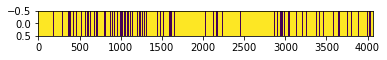

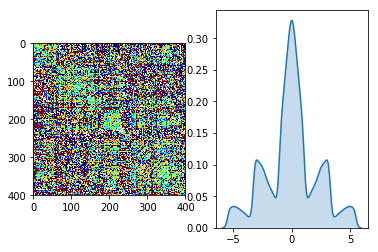

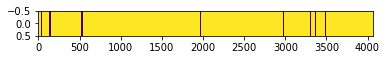

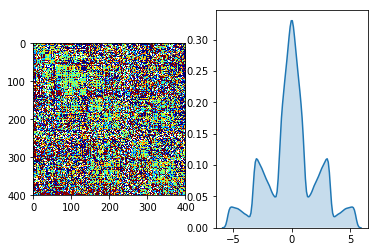

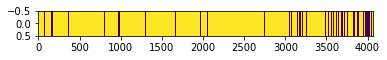

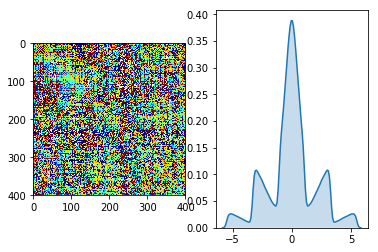

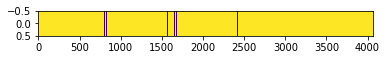

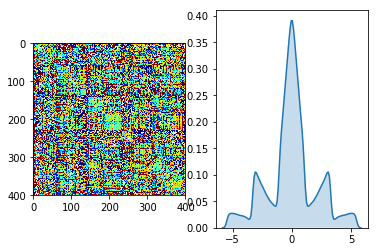

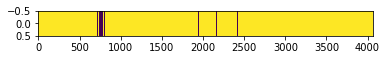

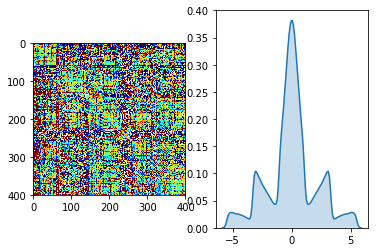

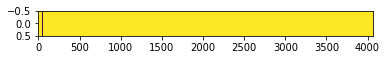

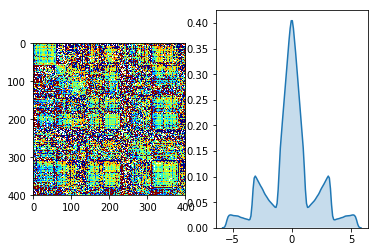

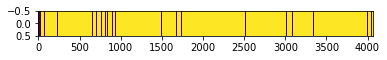

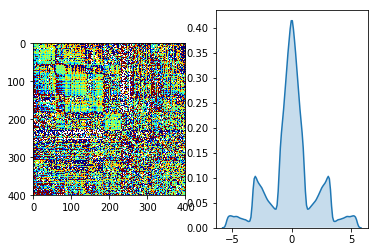

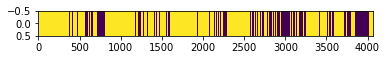

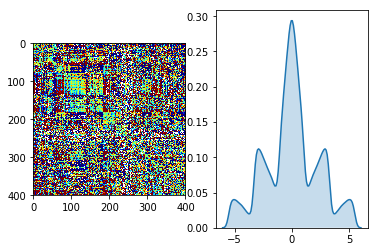

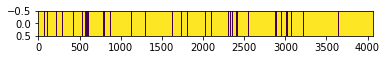

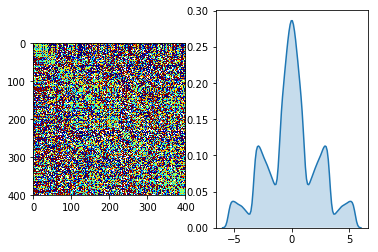

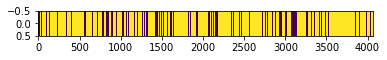

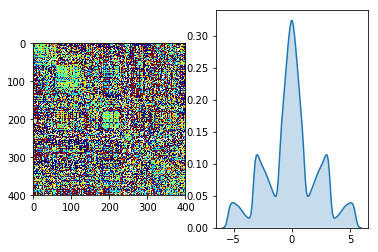

In [5]:
for sub in subjects:
    plt.figure()
    plt.imshow(tmask_rest[sub].values.T, aspect=300)
    plt.figure()
    niwaves.lag_sort(lags_rest[sub], community=community)

/home/vagrant/miniconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


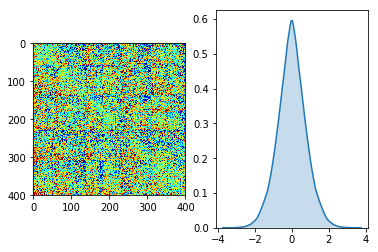

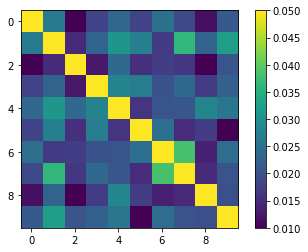

In [6]:
group = np.zeros([len(subjects), len(community), len(community)])
groupr = {}
#np.zeros([len(subjects), len(community) * len(community)])
for i, sub in enumerate(subjects):
    group[i,:,:] = lags_rest[sub]
    groupr[sub] = lags_rest[sub].ravel()
groupmean = np.nanmean(group, axis=0).squeeze()
niwaves.lag_sort(groupmean, community=community)
plt.figure()
plt.imshow(pd.DataFrame(groupr).corr(), vmin=0.01, vmax=0.05)
plt.colorbar();

In [7]:
# Rest
# Currently reruns the analysis at the session level.
ts_rest = {}
ts_motion = {}
lags_rest = {}
peaks_rest = {}
tmask_rest = {}
for sub in subjects:
    lags_rest[sub] = {}
    peaks_rest[sub] = {}
    tmask_rest[sub] = {}
    for ses in sessions:
        ts_rest[ses] = pd.read_csv(ts['task-rest'][sub][ses]['run-01']['roi'][0],
                                   sep=' ', header=None)
        ts_motion[ses] = pd.read_csv(ts['task-rest'][sub][ses]['run-01']['motion'][0],
                                     sep=' ', header=None)
        tmask_rest[sub][ses] = ts_motion[ses] < 0.2
        lags_rest[sub][ses], peaks_rest[sub][ses] = niwaves.lag_analysis(timeseries1=ts_rest[ses].values,
                                                                         tmask=tmask_rest[sub][ses].values,
                                                                         sample_time=2.2,
                                                                         min_block=10,
                                                                         lagmax=3)

In [8]:
groupr = {}
for sub in subjects:
    for ses in sessions:
        groupr[(sub, ses)] = lags_rest[sub][ses].ravel()
groupr = pd.DataFrame(groupr)
groupcorr = groupr.corr()

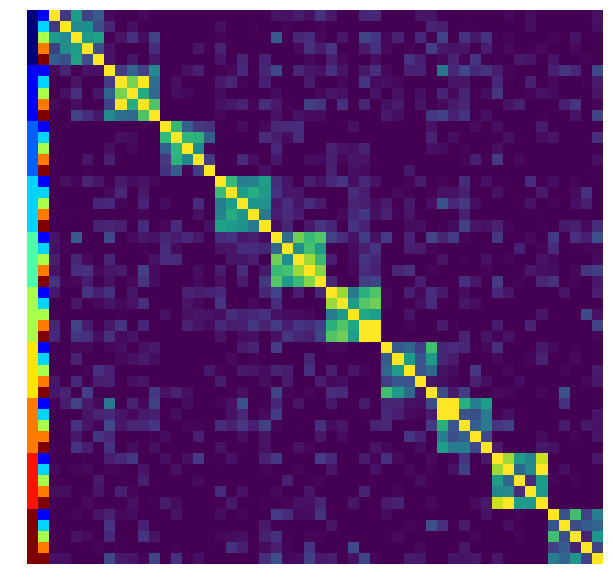

In [9]:
fig_width = 8
fig_height = fig_width * 50/52

seskey = np.array([1,2,3,4,5]*10, ndmin=2)
subkey = np.array([i for i in range(1,11) for k in range(5)], ndmin=2)
keys = np.hstack([subkey.T, 2*seskey.T])
f, (p0, p1) = plt.subplots(1,2, 
                           figsize=(fig_width, fig_height),
                           gridspec_kw = {'width_ratios':[2, 50], 'height_ratios':[50]})
p0.imshow(keys, cmap='jet')
p1.imshow(groupcorr,
          vmin=0.01,
          vmax=0.08)
p0.axis('off')
p1.axis('off')
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
plt.show()

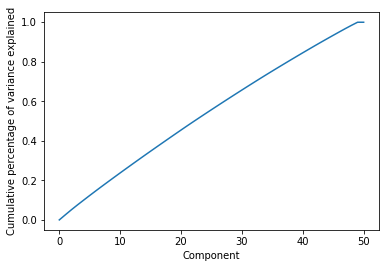

In [10]:
pca = decomposition.PCA()
# For newer versions of sklearn, use this
#imp = sklearn.impute.SimpleImputer(missing_values=np.nan, strategy='constant')
imp = preprocessing.Imputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(groupr.values.T)

# Impute our data, then train
groupr_imp = imp.transform(groupr.values.T)
pcs = pca.fit_transform(groupr_imp)

plt.figure()
plt.plot(np.hstack([[0], np.cumsum(pca.explained_variance_ratio_)]))
plt.xlabel('Component')
plt.ylabel('Cumulative percentage of variance explained');

/home/vagrant/miniconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


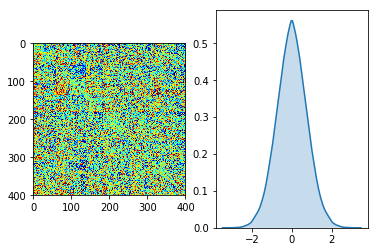

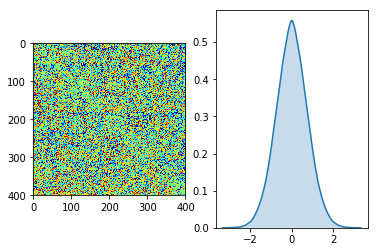

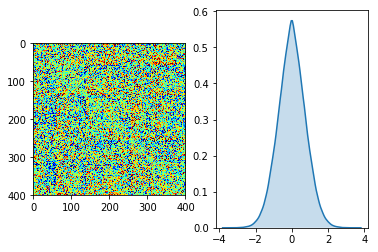

In [11]:
niwaves.lag_sort(pca.components_[0,:].reshape(400,400)*300, community=community)
plt.figure()
niwaves.lag_sort(pca.components_[1,:].reshape(400,400)*300, community=community)
plt.figure()
niwaves.lag_sort(pca.components_[2,:].reshape(400,400)*300, community=community)